## Building the model
### ARCH and GARCH Models
Both Autoregressive Conditional Heteroscedasticity and General Autoregressive Conditional Heteroscedasticity are a class of time series models used to estimate variance based on past values of variance. Both models assume time-varying volatilty i.e heteroscedasticity and are an alternative to models that assume constant variance. <br>
**ARCH Models** <br>
The conditional variance, denoted as σ^2(t), is expressed as a function of lagged squared residuals or error terms. The model assumes that the variance at each time point is a weighted sum of the squared past residuals.<br>
Let $\epsilon _{t}$ be the error term (from some mean process, say, $\varepsilon_t = r_t - \mu$
). The error term can be split into a stochastic part, z$_{t}$ and a deterministic part, $\sigma_t$:<br>
  ${\displaystyle ~\epsilon _{t}=\sigma _{t}z_{t}~}$ <br>
From [wiki](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) page on ARCH(p): <br>
${\displaystyle \sigma _{t}^{2}=\alpha _{0}+\alpha _{1}\epsilon _{t-1}^{2}+\cdots +\alpha _{q}\epsilon _{t-q}^{2}=\alpha _{0}+\sum _{i=1}^{q}\alpha _{i}\epsilon _{t-i}^{2}}$ <br>
**GARCH Models** <br>
The GARCH model is an extension of ARCH that incorporates a moving average component together with the autoregressive component. Here,σ^2(t), is expressed as a function of both past squared errors and past conditional variances.<br>
GARCH(p,q) <br>
${\displaystyle \sigma _{t}^{2}=\omega +\alpha _{1}\epsilon _{t-1}^{2}+\cdots +\alpha _{q}\epsilon _{t-q}^{2}+\beta _{1}\sigma _{t-1}^{2}+\cdots +\beta _{p}\sigma _{t-p}^{2}=\omega +\sum _{i=1}^{q}\alpha _{i}\epsilon _{t-i}^{2}+\sum _{i=1}^{p}\beta _{i}\sigma _{t-i}^{2}}$

**Import data** <br>
We have defined a method in main.py for wrangling data which did in the previous notebook so that we dont have to repeat ourselves.

In [64]:
import sqlite3
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from main import BuildModel
from src.data import SQLRepository
from src.data_utils import get_connection,combine_files
from arch import arch_model
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
conn = get_connection()
repo= SQLRepository(conn)


In [3]:
build_model=BuildModel("scom_prices", repo)

In [4]:
returns =build_model.wrangle_data()

In [5]:
type(returns)

pandas.core.series.Series

**Split Data**

Before building the model we will split the data into training and test.Since this is a time series data, the training will contain the earliest 80% of the data while
 test latest 20%. I.e the split is not randomized. Test set is not defined here because we will use Walk-Forward validation to evaluate model valuation.


In [17]:
cutoff= int(len(returns) * 0.8)
returns_train=returns.iloc[:cutoff]
print("returns type: ",type(returns_train))
print("returns shape: ",returns_train.shape)
returns.tail()

returns type:  <class 'pandas.core.series.Series'>
returns shape:  (1998,)


Date
2025-05-19    0.000000
2025-05-20   -1.253133
2025-05-21    0.761421
2025-05-22    0.000000
2025-05-23    0.251889
Name: return, dtype: float64

**Build and Train model** <br>
GARCH(1,1) performed better(in terms of coefficients which were statistically significant i.e p-value < 0.05) 
compared to GARCH(2,2) and GARCH(3,3). You could actually check by changing by testing p & q with values 2,3.


In [24]:
model=arch_model(
    returns_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)
print("Model type: ", type(model))

Model type:  <class 'arch.univariate.base.ARCHModelResult'>


In [25]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3705.12
Distribution:                  Normal   AIC:                           7418.24
Method:            Maximum Likelihood   BIC:                           7440.64
                                        No. Observations:                 1998
Date:                Fri, May 30 2025   Df Residuals:                     1997
Time:                        20:06:45   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0379  3.302e-02      1.149      0.251 [-2.678e-02,  0.103]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.4334      0.188      2.306  2.110e-02 [6.507e-02,  0.802]
alpha[1]       0.1942  5.395e-02      3.600  3.180e-04 [8.849e-02,  0.300]
beta[1]        0.6573      0.110      5.988  2.119e-09   [  0.442,  0.872]
==========================================================================

Covariance estimator: robust
"""

**Plot of Returns vs Predictions** <br>
To check the predictions we use 'model.conditional_volality'

In [34]:
model.conditional_volatility.head()

Date
2015-05-18    1.668742
2015-05-19    1.553691
2015-05-20    1.443165
2015-05-21    1.405178
2015-05-22    1.380738
Name: cond_vol, dtype: float64

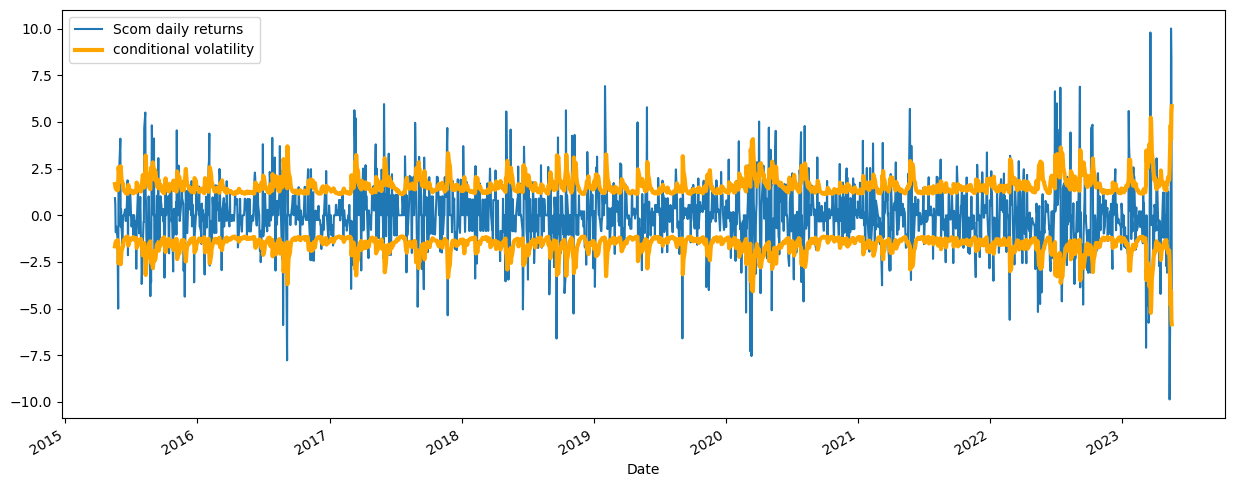

In [53]:
fig, ax = plt.subplots(figsize=(15, 6))
#Plot returns
returns_train.plot(ax=ax, label="Scom daily returns")
# conditional volatilty * 1
(1*model.conditional_volatility).plot(
    ax=ax,
    color="orange",
    label="conditional volatility",
    linewidth=3
)
# conditional volatilty * -1
(-1*model.conditional_volatility).rename("").plot(
    ax=ax,
    color="orange",
    linewidth=3
)
#Label axes
plt.xlabel("Date")
#Add legend
plt.legend();

The model does a fairly good job at capturing volatility clustering i.e periods of high and low volatility.

**Stadardized Residuals** <br>
*1. Line plot*

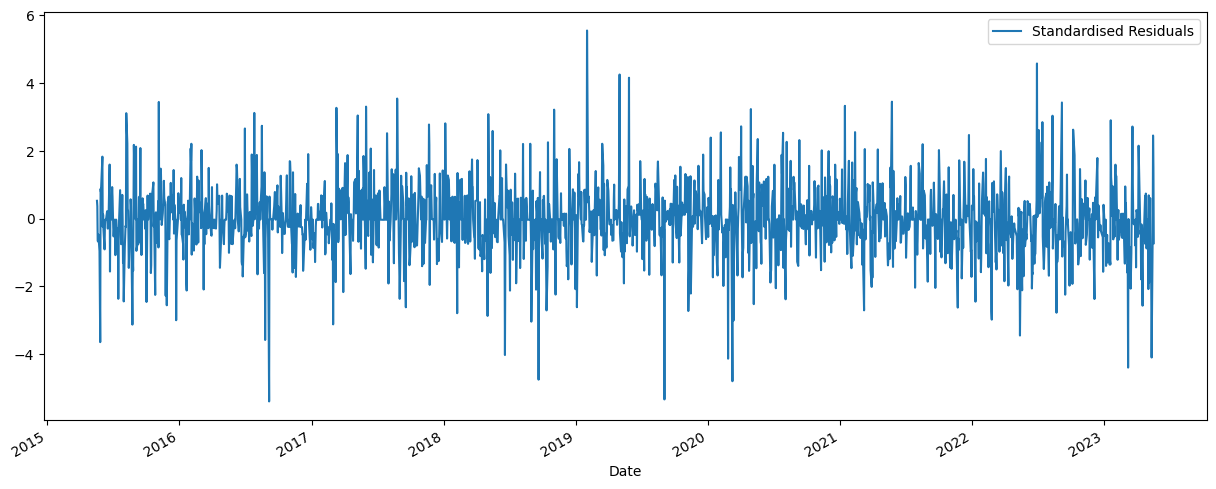

In [55]:
fig, ax = plt.subplots(figsize=(15, 6))
model.std_resid.plot(ax=ax, label="Standardized Residuals")
#Label axes
plt.xlabel("Date")
#Add legend
plt.legend();

The standardised residuals do not display any trends and appears random like white noise process. This is  
suggests that the model captured the dynamics of the time series data.

*2.Histogram plot*

Text(0.5, 1.0, 'Distribution of Standardised Residuals')

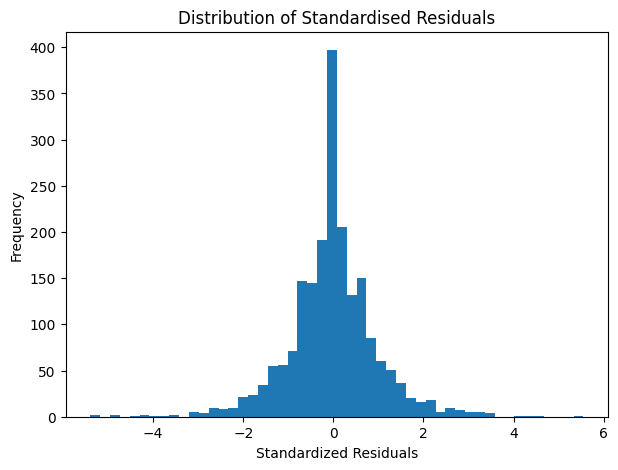

In [60]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.hist(model.std_resid, bins=50)
#Label axes
plt.xlabel("Standardized Residuals")
plt.ylabel("Frequency")
#Add title
plt.title("Distribution of Standardized Residuals")


The distribution is approximately normal but fat-tailed but that is to be expected as the returns were also heavy tailed. 

*3.ACF plot*

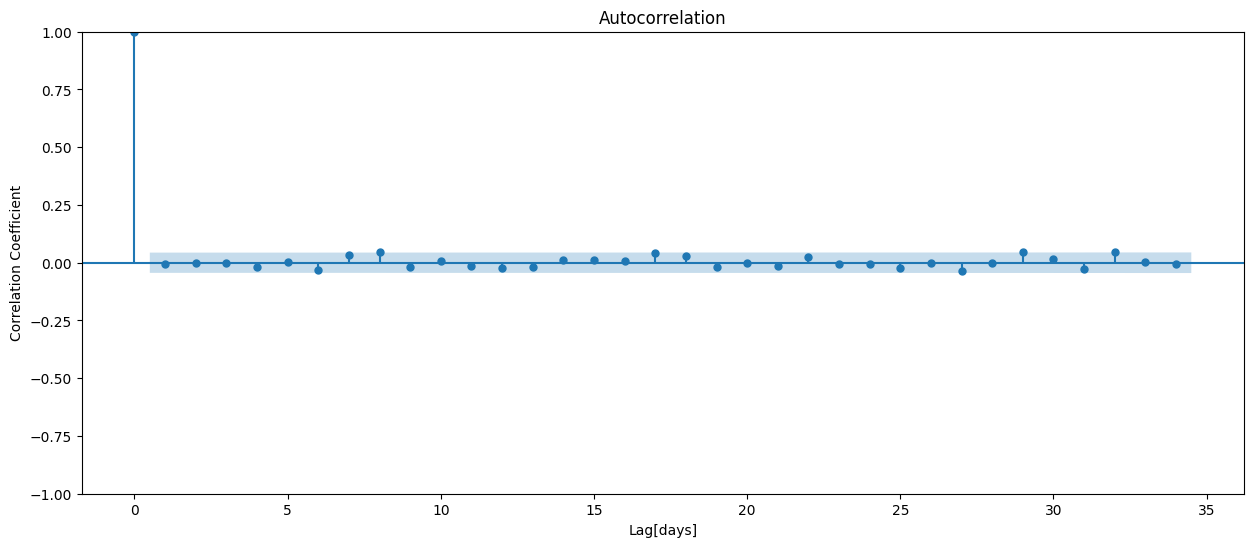

In [65]:
fig, ax = plt.subplots(figsize=(15, 6))
#Create ACF of squared returns
plot_acf(model.std_resid **2, ax=ax)
plt.xlabel("Lag[days]")
plt.ylabel("Correlation Coefficient");

The ACF plot shows that our residuals show no siginificant autocorrelations and behave just like white noise 
so the model is fitted well. The next step is model evaluation on the next notebook